In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import ipywidgets as widgets
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

plt.style.use('ggplot')

# **Cleaning the Data**

The first dataset I have loaded is from the GISS Surface Temperature Analysis version 4 (GISTEMP v4), an estimate of global surface temperature change. The values under each month column are the monthly mean deviation from an average value. For each month, the average value is simply the mean of the monthly average temperatures from the years 1951 to 1980. 

The second dataset is the PRIMAP-hist national historical emissions time series (1750-2021).

## **GISS Data**

In [2]:
gw_temp_df = pd.read_csv('./GLB.Ts+dSST.csv', sep='\t')

In [3]:
column_names = gw_temp_df.iloc[0].str.split(',').explode().tolist()
new_df = pd.DataFrame(columns=column_names)

In [4]:
data_df = gw_temp_df.iloc[1:]

for index, row in data_df.iterrows():
    raw_data = row.str.split(',').explode().tolist()
    raw_data_df = pd.DataFrame([raw_data], columns=new_df.columns)
    new_df = pd.concat([new_df, raw_data_df], ignore_index=True)

In [5]:
new_df = new_df[new_df['Year'] < '2023']
new_df = new_df.replace('***', np.nan)

In [6]:
new_df.Year = new_df.Year.astype('int')

In [7]:
float_cols = [col for col in new_df.columns if col != 'Year']
for col in float_cols:
    new_df[col] = new_df[col].astype('float')

In [8]:
monthly_data = new_df.iloc[:,0:13]

## **Historical Greenhouse Gas Emission Data**

In [9]:
ghg_raw_df = pd.read_csv('./Guetschow-et-al-2023a-PRIMAP-hist_v2.4.2_final_09-Mar-2023.csv')

In [10]:
cols_to_keep = [col for col in ghg_raw_df.columns if col not in ['source', 'scenario (PRIMAP-hist)', 'unit', 'category (IPCC2006_PRIMAP)']]
ghg_filtered_df = ghg_raw_df[cols_to_keep]

In [11]:
ghg_grouped = ghg_filtered_df.groupby('entity').sum()
ghg_grouped.reset_index(inplace=True)

/var/folders/3s/6yq71yf16yq1y9c5zlss3syc0000gn/T/ipykernel_49219/1526667985.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ghg_grouped = ghg_filtered_df.groupby('entity').sum()


In [12]:
melted_df = ghg_grouped.melt(id_vars=['entity'], var_name='Year', value_name='Value')
reshaped_df = melted_df.pivot(index='Year', columns='entity', values='Value')
ghg_df = reshaped_df.reset_index()

In [13]:
ghg_df.Year = ghg_df.Year.astype('int')

## **Merging the two dataframes**

In [14]:
ghg_limited = ghg_df[ghg_df['Year']>1879]
monthly_limited = monthly_data[monthly_data['Year']<2022]

In [15]:
full_ghg_anomaly_df = pd.merge(ghg_limited, monthly_limited, how='outer', on='Year')

# **Are Temperatures Rising?**

Here, I wish to explore a simple narrative- is the globe getting hotter?
The first thing that I would have to do is check the distributions and trends in my temperature data.

In [40]:
def update_histogram(selected_month):
    plt.figure(figsize=(8, 6))
    plt.hist(monthly_data[selected_month], bins='auto')
    plt.title(f'Temperature Anomaly Histogram for {selected_month}')
    plt.xlabel('Temperature Anomaly')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


month_columns = monthly_data.columns[1:]
month_selector = widgets.Dropdown(
    options=month_columns,
    description='Select Month:',
    disabled=False
)

output_plot = widgets.Output()

def on_month_change(change):
    selected_month = change.new
    with output_plot:
        output_plot.clear_output()
        update_histogram(selected_month)

month_selector.observe(on_month_change, names='value')

display(month_selector)
display(output_plot)

Dropdown(description='Select Month:', options=('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', …

Output()

From this plot, we can see that for most months, the temperature anomalies are centered around 0. However, there seem to be a long tail of the distributions to the right side of 0, which we can assume indicates that there have been more extreme hot years (i.e. temperature anomaly > 0) than there have been extreme cool years. Let us see if we can find any patterns if we plot the data across a whole year.

In [41]:
def update_line_plot(selected_year):
    plt.figure(figsize=(8, 6))
    selected_data = monthly_data[monthly_data['Year'] == selected_year].iloc[0, 1:]
    plt.plot(month_columns, selected_data, marker='o')
    plt.axhline(y=0, color='blue', linestyle='--', label='anomaly=0')
    plt.title(f'Temperature Anomaly vs. Month for {selected_year}')
    plt.xlabel('Month')
    plt.ylabel('Temperature Anomaly')
    plt.grid(True)
    plt.show()

year_selector = widgets.Dropdown(
    options=monthly_data['Year'].values,
    description='Select Year:',
    disabled=False
)

output_plot = widgets.Output()

def on_year_change(change):
    selected_year = change.new
    with output_plot:
        output_plot.clear_output()
        update_line_plot(selected_year)

year_selector.observe(on_year_change, names='value')

display(year_selector)
display(output_plot)

Dropdown(description='Select Year:', options=(1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890…

Output()

We can scroll through the years to see how the temperature anomaly changes with time. As we can see:
* There doesn't seem to be any common shape for the graph on a year to year basis.
* The anomaly starts off below the dashed blue line, for most years between the starting year of 1880 and the years which are used to define the anomaly between 1951 and 1980. 
* Moving forward, the anomaly starts living more and more above the dashed blue line.

We can quantify this a bit more by calculating the yearly average anomaly, and plotting how that has changed over the years. To calculate this, we will take the average anomaly for each month and calculate the mean. Doing this for each year will give us a series of values we can plot.

In [37]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
full_ghg_anomaly_df['yearly_avg_anomaly'] = full_ghg_anomaly_df[months].apply(lambda row: row.mean(), axis=1)

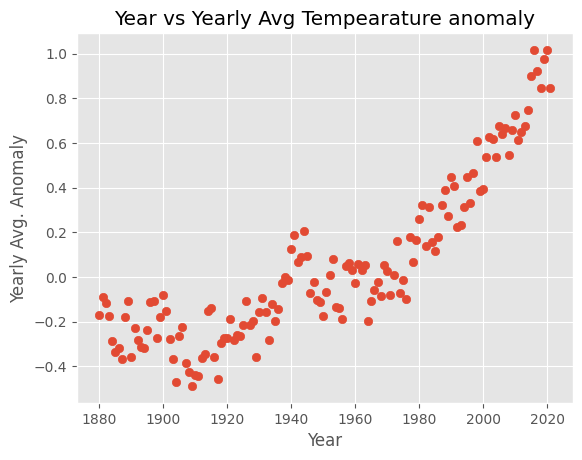

In [39]:
plt.scatter(full_ghg_anomaly_df.Year, full_ghg_anomaly_df.yearly_avg_anomaly)
plt.xlabel('Year')
plt.ylabel('Yearly Avg. Anomaly')
plt.title('Year vs Yearly Avg Tempearature anomaly')
plt.show()

This graph clearly shows us what we have been trying to see. There is a very clear picture that the yearly average temperature anomaly is increasing with time. What can we observe about this graph?

* From 1880-1915, the anomaly seems to be either holding stable or dropping a little. This could be due to the fact that in the industrialized world at the time there were no large scale wars, or other drivers of increase in manufacturing output.
* From 1915-1945, there is a clear rise in anomaly. This can be explained as the effect of the industrial ramp-up during WW1 and WW2.
* From 1945-1970, the anomaly seems to drop. This could be an interesting question to consider further. What happened in the postwar period? What role did decolonization play in this?
* From 1970-present, there is a more or less straight line upwards. This can likely be explained due to the start of industrialization in the rest of the world (for example in India and China).

Industrialization necessitates greater energy output to sustain production. Traditionally, coal and other fossil fuels have fulfilled this demand, but their combustion releases greenhouse gases. This raises a question: what proportion of the rising temperature anomaly can be attributed to these emissions? In the following section, I will try to answer this.

# **Greenhouse Gas Emissions**

Now that we have seen that temperatures are rising, let us check the effect of the most commonly cited source: greenhouse gas emissions. With this in mind, let us plot greenhouse gas emissions as a function of time. 

In [42]:
def update_line_plot(selected_col):
    plt.figure(figsize=(8, 6))
    y_values = ghg_df[selected_col]
    y_units = ghg_raw_df[ghg_raw_df['entity']==selected_col].unit.iloc[0]
    plt.plot(ghg_df['Year'], y_values)
    plt.xticks(rotation=90)
    plt.gca().xaxis.set_major_locator(MultipleLocator(10))  # Display every 5th x-axis tick label
    plt.title(f'Emissions vs. Year for {selected_col}')
    plt.xlabel('Year')
    plt.ylabel(f'{selected_col} Emissions ({y_units})')
    plt.grid(True)
    plt.show()

gas_columns = ghg_df.columns[1:]
gas_selector = widgets.Dropdown(
    options=gas_columns,
    description='Select gas:',
    disabled=False
)

output_plot = widgets.Output()

def on_gas_change(change):
    selected_col = change.new
    with output_plot:
        output_plot.clear_output()
        update_line_plot(selected_col)

gas_selector.observe(on_gas_change, names='value')

display(gas_selector)
display(output_plot)

Dropdown(description='Select gas:', options=('CH4', 'CO2', 'FGASES (AR4GWP100)', 'FGASES (SARGWP100)', 'HFCS (…

Output()

## **What is driving the current rise in temperatures?**

We know that at the beginning of the Industrial Revolution, the main source of energy was coal. The main greenhouse gas emitted in burning coal is CO2. This graph marks up nicely with our plots of Temperature anomaly vs Year. Let's make a scatterplot of the temperature anomaly with CO2 emissions.

In [44]:
full_ghg_anomaly_df.head()

,Year,CH4,CO2,FGASES (AR4GWP100),FGASES (SARGWP100),HFCS (AR4GWP100),HFCS (SARGWP100),KYOTOGHG (AR4GWP100),KYOTOGHG (SARGWP100),N2O,...,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,yearly_avg_anomaly
0,1880,1.240707e+06,2.021156e+07,1063.683398,935.164677,0.0,0.0,5.635959e+07,5.160544e+07,18636.252215,...,-0.16,-0.10,-0.21,-0.18,-0.10,-0.15,-0.24,-0.22,-0.18,-0.171667
1,1881,1.255499e+06,2.076578e+07,1063.683398,935.166677,0.0,0.0,5.735303e+07,5.255900e+07,18840.151502,...,0.05,0.06,-0.19,0.00,-0.04,-0.15,-0.22,-0.19,-0.07,-0.088333
2,1882,1.271582e+06,2.206157e+07,1063.685398,935.570897,0.0,0.0,5.906546e+07,5.419856e+07,19021.946052,...,-0.17,-0.15,-0.23,-0.17,-0.07,-0.15,-0.24,-0.17,-0.36,-0.114167
3,1883,1.288817e+06,2.351326e+07,1063.887418,935.612897,0.0,0.0,6.096004e+07,5.602516e+07,19178.649485,...,-0.18,-0.18,-0.08,-0.07,-0.14,-0.22,-0.11,-0.23,-0.11,-0.175000
4,1884,1.298212e+06,2.386213e+07,1064.127424,935.818897,0.0,0.0,6.157835e+07,5.664208e+07,19311.635712,...,-0.40,-0.34,-0.36,-0.30,-0.28,-0.27,-0.25,-0.34,-0.31,-0.285000


In [46]:
def update_scatter_plot(selected_gas):
    plt.scatter(full_ghg_anomaly_df[selected_gas], full_ghg_anomaly_df['yearly_avg_anomaly'], marker='o')
    y_units = ghg_raw_df[ghg_raw_df['entity']==selected_gas].unit.iloc[0]
    slope, intercept = np.polyfit(full_ghg_anomaly_df[selected_gas], full_ghg_anomaly_df['yearly_avg_anomaly'], 1)
    best_fit_line = slope * ghg_limited[selected_gas] + intercept
    plt.plot(ghg_limited[selected_gas], best_fit_line, color='blue', label=f'Line of Best Fit (Slope: {slope})')
    plt.title(f'Yearly Temperature Anomaly vs. {selected_gas} Emissions')
    plt.xlabel(f'{selected_gas} emissions ({y_units})')
    plt.ylabel('Temperature Anomaly')
    plt.legend()
    plt.grid(True)
    plt.show()

gas_columns = ghg_df.columns[1:]
gas_selector = widgets.Dropdown(
    options=gas_columns,
    description='Select gas:',
    disabled=False
)

output_plot = widgets.Output()

def on_gas_change(change):
    selected_col = change.new
    with output_plot:
        output_plot.clear_output()
        update_scatter_plot(selected_col)

gas_selector.observe(on_gas_change, names='value')

display(gas_selector)
display(output_plot)

Dropdown(description='Select gas:', options=('CH4', 'CO2', 'FGASES (AR4GWP100)', 'FGASES (SARGWP100)', 'HFCS (…

Output()

There seems to be a clear trend here. Rising greenhouse gas (GHG) emissions seem to correspond to rising temperature anomaly. This seems to line up well with what we know from science. Realistically, it is the concentration of GHGs in the atmosphere that trap heat from the Earth's surface from radiating back into space. This concentration of GHGs, we would expect, should be proportional to the amount of GHGs emitted over time, thus giving rise to the positive slopes in the graphs we plot above. Let us take a look at the correlation values for each of the gases/baskets of GHGs.

## **Correlations!**

In [49]:
cols_to_check = [col for col in full_ghg_anomaly_df.columns if col not in months + ['yearly_avg_anomaly', 'Year']]

highest_corr_column = None
highest_corr_value = -1
for col in cols_to_check:
    corr_value = full_ghg_anomaly_df['yearly_avg_anomaly'].corr(full_ghg_anomaly_df[col])
    print(f'Correlation of {col} emissions with temperature anomaly: {corr_value}')
    if corr_value > highest_corr_value:
        highest_corr_value = corr_value
        highest_corr_column = col

print(f'{highest_corr_column} emissions have the highest correlation with yearly average anomaly, with a correlation of {highest_corr_value}')

Correlation of CH4 emissions with temperature anomaly: 0.8988619076028566
Correlation of CO2 emissions with temperature anomaly: 0.9240029909774532
Correlation of FGASES (AR4GWP100) emissions with temperature anomaly: 0.9070296718217028
Correlation of FGASES (SARGWP100) emissions with temperature anomaly: 0.9087968617492858
Correlation of HFCS (AR4GWP100) emissions with temperature anomaly: 0.8537632706530416
Correlation of HFCS (SARGWP100) emissions with temperature anomaly: 0.852062321824396
Correlation of KYOTOGHG (AR4GWP100) emissions with temperature anomaly: 0.9215884939327806
Correlation of KYOTOGHG (SARGWP100) emissions with temperature anomaly: 0.9217042419000584
Correlation of N2O emissions with temperature anomaly: 0.8837215792227213
Correlation of NF3 emissions with temperature anomaly: 0.7864083911461084
Correlation of PFCS (AR4GWP100) emissions with temperature anomaly: 0.7898126695147472
Correlation of PFCS (SARGWP100) emissions with temperature anomaly: 0.79798362986870

As we can see, all the GHG seem to have fairly strong correlation values with temperature anomaly. How much of the rise of temperature anomaly can be explained by the GHG emissions? We will use the $R^2$ metric of a simple linear model.

## **Simple Linear Model of Anomaly and GHG emissions**

We will ignore the baskets of GHGs since they mostly contain the other GHGs within them.

In [60]:
gas_cols = ['CH4', 'CO2', 'N2O', 'NF3', 'SF6']
X = full_ghg_anomaly_df[gas_cols]
y = full_ghg_anomaly_df.yearly_avg_anomaly

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [61]:
model = LinearRegression()

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
r2 = r2_score(y_true=y_test, y_pred=y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.022957041180677436
R-squared: 0.81700828900257


The $R^2$ value essentially indicates how much of the variability in the yearly average temperature anomaly is explained by the GHG emissions. These metrics suggest that the linear regression model is performing well on the data, and that the GHG emissions can explain 81.7% of the variability in the yearly average temperature anomaly.

# **Conclusions**

The analysis has provided insights into the dynamics of global surface temperature change and its association with greenhouse gas emissions. 

We saw a consistent upward trend in the yearly average anomaly.

When focusing on the role of greenhouse gas emissions, particularly CO2, we saw a strong correlation between these emissions and temperature anomalies. The data underscored the significance of CO2 as a leading contributor to the observed temperature changes. Employing a simple linear model, we saw the extent to which GHG emissions account for the variability in temperature anomalies, revealing that these emissions explain a substantial portion of the observed changes (around 81.7%).

# **Further Questions to Consider**

* What caused the decline in temperature from around 1895 to 1915?
* What caused the decline in temperature from around 1945 to 1970?
* In the scatterplot of yearly average temperature anomaly vs. GHG emission, there seems to be an sinusoidal component on top of the linear component. What could explain that behavior?
* What is the actual relationship between GHG emissions, GHG concentration in the atmosphere, and monthly temperature anomaly? Is this something that can be concretely derived from first principles?  How good is that calculation as compared to the observed values?
* How good are some carbon negative strategies at capturing carbon-based GHGs?